In [1]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm


In [2]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [3]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

Функция построения графиков 

In [5]:
def plot_training_results(train_losses, val_losses, val_accuracies, epochs_list):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(range(len(train_losses)), train_losses, label='Train Loss', marker='o')
    ax1.plot(epochs_list, val_losses, label='Validation Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs_list, val_accuracies, label='Validation Accuracy', color='green', marker='^')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

Для варьирования были выбраны следующие параметры:
1. Колличество ядер = {10, 16, 32, 64}
2. Метод опимизации = {Adam, RMSprop, Adadelta}
   (SGD пользоваться нельзя а другие оптимизаторы в torch.optim являются модификаторами либо для Adam, либо для SGD)
4. Метод подсчета ошибки = {F.nll_loss, F.kl_div}

Лучшим методом оптимизации - Adam, независимо от типа ошибки 

Best Accurasy = 0.988 > 0.9747

Серия Экспериментов №1

При увеличении колличества ядер увеличивается общий скор

Инварианты: метод оптимизации = Adam, Метод подсчета ошибки = F.nll_loss

In [6]:
def train(model, optimizer, n_epochs=5):
    train_losses = []
    val_losses = []
    val_accuracies = []
    epochs_list = []
    
    for epoch in range(n_epochs):
        epoch_train_losses = []
        for x_train, y_train in train_dataloader:
            y_pred = model(x_train)
            loss = F.nll_loss(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_train_losses.append(loss.item())
        
        train_losses.append(np.mean(epoch_train_losses))
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                y_pred = model(x_val)
                loss = F.nll_loss(y_pred, y_val)
                val_loss.append(loss.item())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

        val_loss_epoch = np.mean(val_loss)
        val_accuracy_epoch = np.mean(val_accuracy)
            
        val_losses.append(val_loss_epoch)
        val_accuracies.append(val_accuracy_epoch)
        epochs_list.append(epoch)
    
    #plot_training_results(train_losses, val_losses, val_accuracies, epochs_list)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'epochs': epochs_list
    }

In [7]:
num_filters = 10
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=5),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   
    nn.Flatten(),
    nn.Linear(6*6*num_filters, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
log_10 = train(model, optimizer, n_epochs=5)

In [8]:
num_filters = 32
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=5),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   
    nn.Flatten(),
    nn.Linear(6*6*num_filters, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
log_32 = train(model, optimizer, n_epochs=5)

In [9]:
num_filters = 64
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=5),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   
    nn.Flatten(),
    nn.Linear(6*6*num_filters, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
log_64 = train(model, optimizer, n_epochs=5)

In [10]:
log_10['val_accuracies']

[np.float64(0.9695),
 np.float64(0.968),
 np.float64(0.9849),
 np.float64(0.9848),
 np.float64(0.9862)]

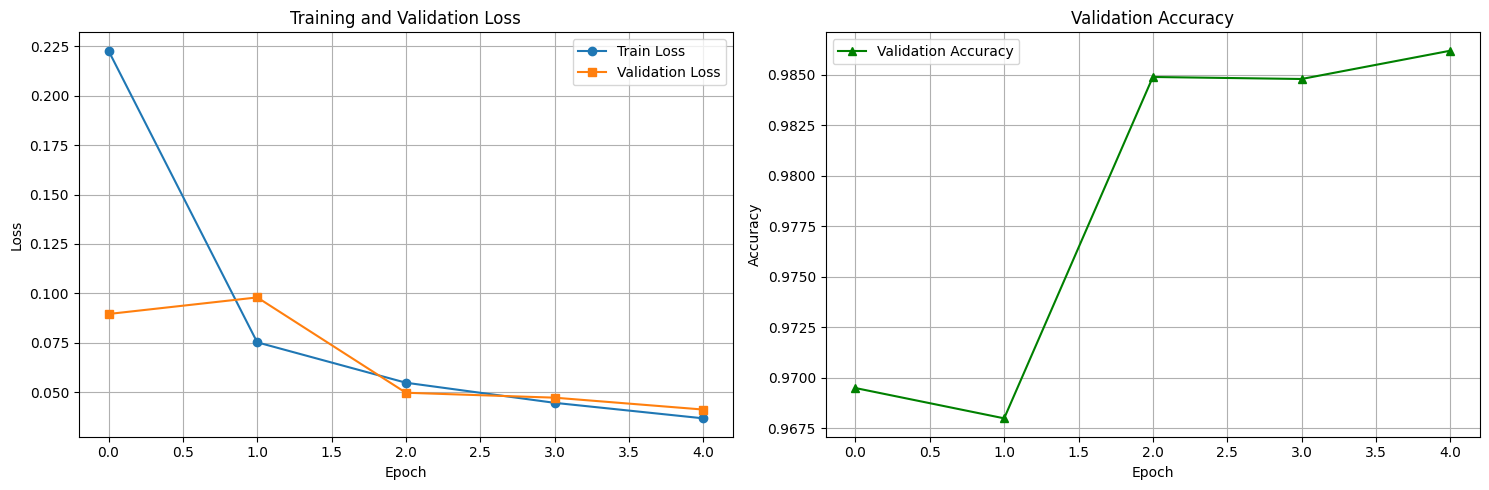

In [11]:
plot_training_results(log_10['train_losses'], log_10['val_losses'], log_10['val_accuracies'], log_10['epochs'])

In [12]:
log_32['val_accuracies']

[np.float64(0.98),
 np.float64(0.9822),
 np.float64(0.9844),
 np.float64(0.9854),
 np.float64(0.9891)]

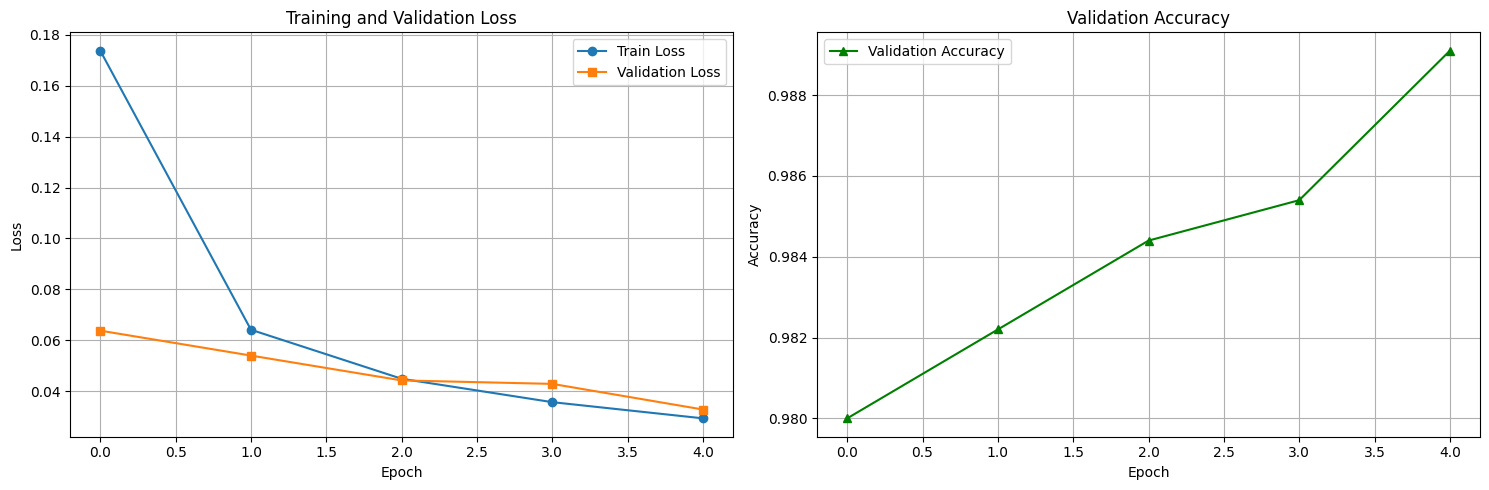

In [13]:
plot_training_results(log_32['train_losses'], log_32['val_losses'], log_32['val_accuracies'], log_32['epochs'])

In [14]:
log_64['val_accuracies']

[np.float64(0.9808),
 np.float64(0.9866),
 np.float64(0.9885),
 np.float64(0.9886),
 np.float64(0.9874)]

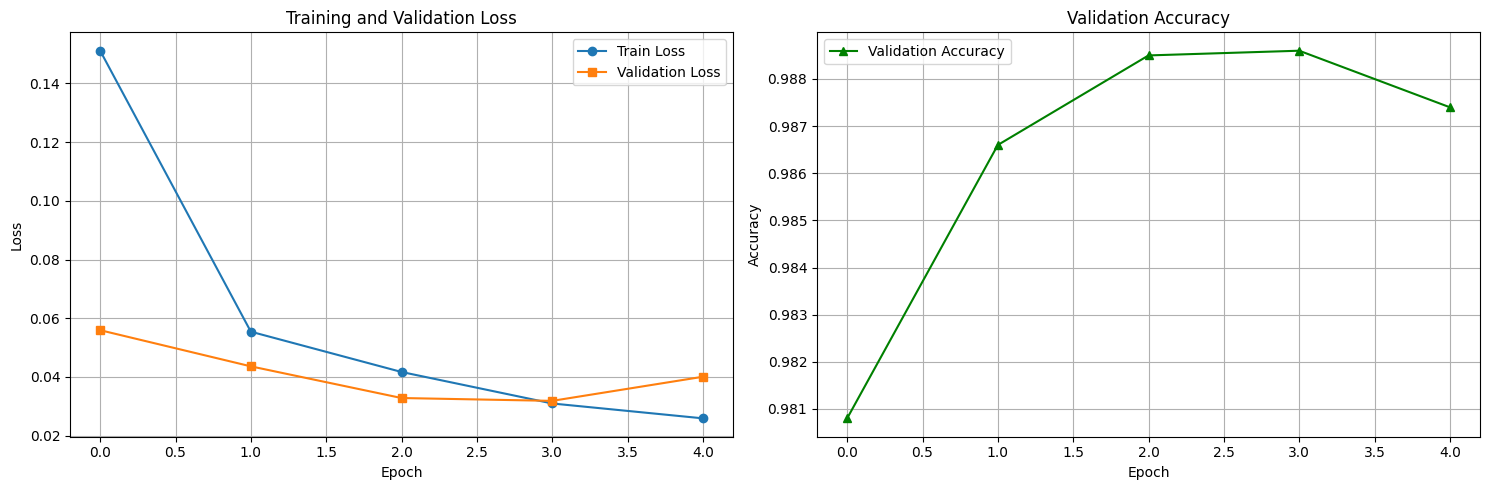

In [15]:
plot_training_results(log_64['train_losses'], log_64['val_losses'], log_64['val_accuracies'], log_64['epochs'])

Из эксперимента видно, что колличество ядер повышает скорость обучения модели за эпоху, однако без механизмов регуляризации быстро переобучается

Эксперимент №2

Колличество ядер - 16

Метод опимизации - Adam

Ошибки варьируются

In [16]:
def train_nll_loss(model, optimizer, n_epochs=5):
    train_losses = []
    val_losses = []
    val_accuracies = []
    epochs_list = []
    
    for epoch in range(n_epochs):
        epoch_train_losses = []
        for x_train, y_train in train_dataloader:
            y_pred = model(x_train)
            loss = F.nll_loss(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_train_losses.append(loss.item())
        
        train_losses.append(np.mean(epoch_train_losses))
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                y_pred = model(x_val)
                loss = F.nll_loss(y_pred, y_val)
                val_loss.append(loss.item())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

        val_loss_epoch = np.mean(val_loss)
        val_accuracy_epoch = np.mean(val_accuracy)
            
        val_losses.append(val_loss_epoch)
        val_accuracies.append(val_accuracy_epoch)
        epochs_list.append(epoch)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'epochs': epochs_list
    }

In [17]:
num_filters = 16
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=5),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   
    nn.Flatten(),
    nn.Linear(6*6*num_filters, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
log_adam_nll = train_nll_loss(model, optimizer, n_epochs=5)

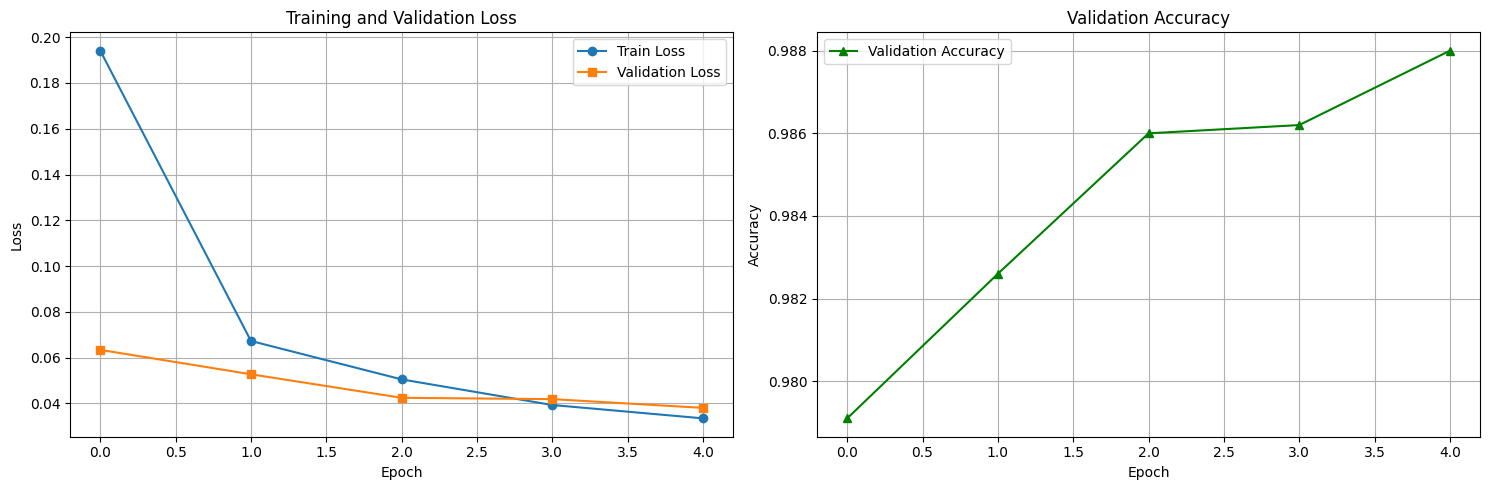

In [19]:
plot_training_results(log_adam_nll['train_losses'], 
                      log_adam_nll['val_losses'], 
                      log_adam_nll['val_accuracies'], 
                      log_adam_nll['epochs'])

In [20]:
log_adam_nll['val_accuracies']

[np.float64(0.9791),
 np.float64(0.9826),
 np.float64(0.986),
 np.float64(0.9862),
 np.float64(0.988)]

In [21]:
def one_hot_targets(y, num_classes):
    return F.one_hot(y, num_classes=num_classes).float()

def train_kl_div(model, optimizer, n_epochs=5, num_classes=10):
    train_losses = []
    val_losses = []
    val_accuracies = []
    epochs_list = []

    for epoch in range(n_epochs):
        epoch_train_losses = []
        model.train()
        for x_train, y_train in train_dataloader:
            log_prob = model(x_train)                     
            target_prob = one_hot_targets(y_train, num_classes)  
            loss = F.kl_div(log_prob, target_prob, reduction='batchmean')
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_train_losses.append(loss.item())

        train_losses.append(np.mean(epoch_train_losses))
        model.eval()
        val_loss_vals = []
        val_correct = []
        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                log_prob = model(x_val)
                target_prob = one_hot_targets(y_val, num_classes)
                loss = F.kl_div(log_prob, target_prob, reduction='batchmean')
                val_loss_vals.append(loss.item())
                preds = torch.argmax(log_prob, dim=1)
                val_correct.extend((preds == y_val).cpu().numpy().tolist())

        val_losses.append(np.mean(val_loss_vals))
        val_accuracies.append(np.mean(val_correct))
        epochs_list.append(epoch)


    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'epochs': epochs_list
    }

In [22]:
num_filters = 16
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=5),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   
    nn.Flatten(),
    nn.Linear(6*6*num_filters, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
log_adam_kl = train_kl_div(model, optimizer, n_epochs=5)

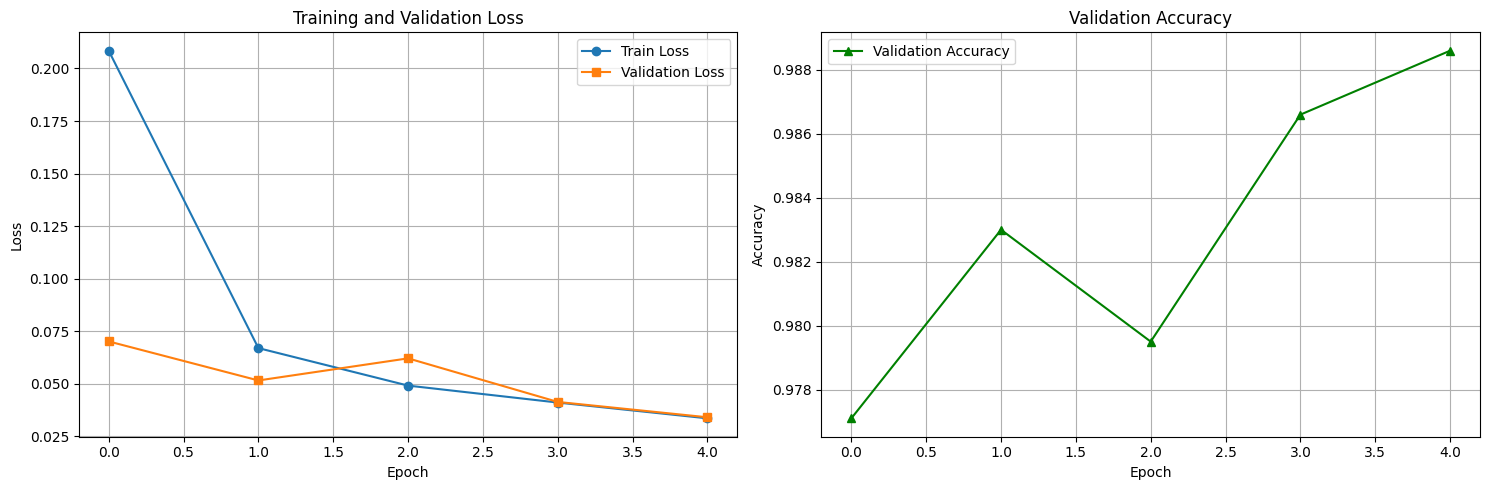

In [24]:
plot_training_results(log_adam_kl['train_losses'], 
                      log_adam_kl['val_losses'], 
                      log_adam_kl['val_accuracies'], 
                      log_adam_kl['epochs'])

In [25]:
log_adam_kl['val_accuracies']

[np.float64(0.9771),
 np.float64(0.983),
 np.float64(0.9795),
 np.float64(0.9866),
 np.float64(0.9886)]

Эксперимент №3

Колличество ядер - 16

Метод опимизации - RMSprop

Ошибки варьируются


In [26]:
num_filters = 16
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=5),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   
    nn.Flatten(),
    nn.Linear(6*6*num_filters, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [27]:
log_RMSprop_nll = train_nll_loss(model, optimizer, n_epochs=5)

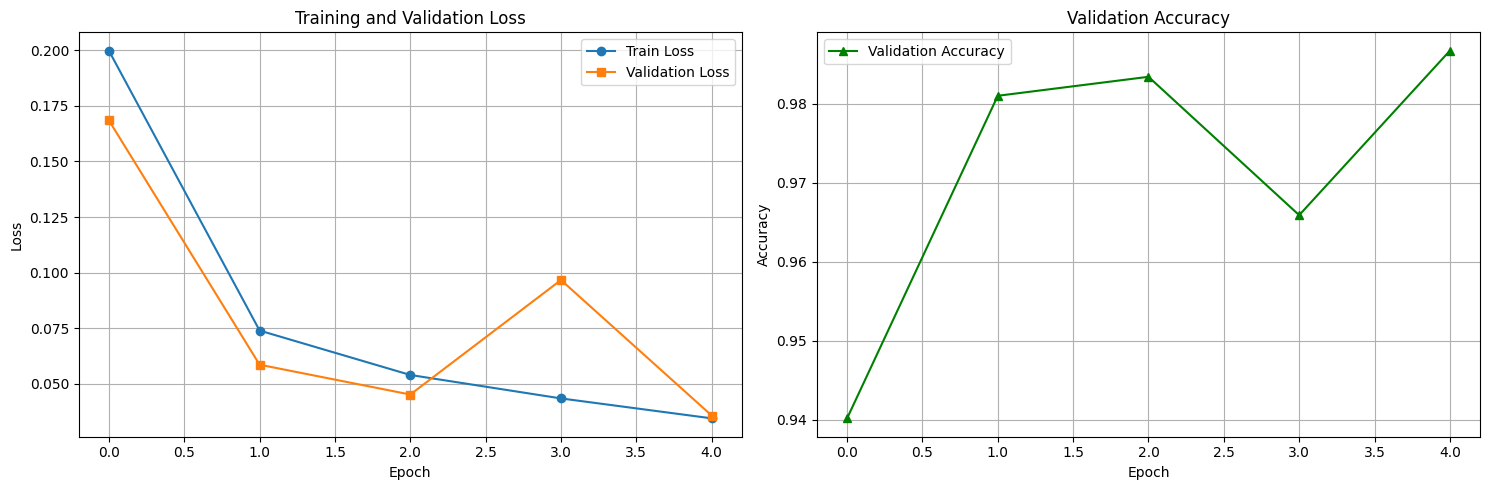

In [28]:
plot_training_results(log_RMSprop_nll['train_losses'], 
                      log_RMSprop_nll['val_losses'], 
                      log_RMSprop_nll['val_accuracies'], 
                      log_RMSprop_nll['epochs'])

In [29]:
log_RMSprop_nll['val_accuracies']

[np.float64(0.9402),
 np.float64(0.981),
 np.float64(0.9834),
 np.float64(0.9659),
 np.float64(0.9867)]

In [30]:
num_filters = 16
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=5),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   
    nn.Flatten(),
    nn.Linear(6*6*num_filters, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [31]:
log_RMSprop_kl = train_kl_div(model, optimizer, n_epochs=5)

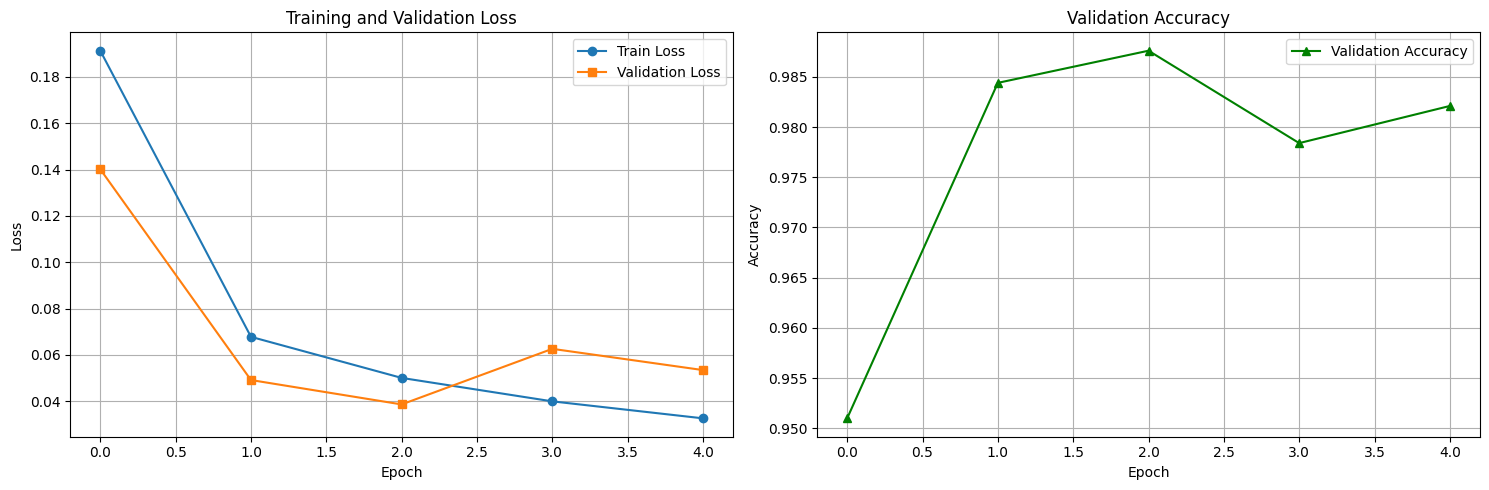

In [32]:
plot_training_results(log_RMSprop_kl['train_losses'], 
                      log_RMSprop_kl['val_losses'], 
                      log_RMSprop_kl['val_accuracies'], 
                      log_RMSprop_kl['epochs'])

In [33]:
log_RMSprop_kl['val_accuracies']

[np.float64(0.951),
 np.float64(0.9844),
 np.float64(0.9876),
 np.float64(0.9784),
 np.float64(0.9821)]

Эксперимент №4

Колличество ядер - 16

Метод опимизации - Adadelta

Ошибки варьируются

In [82]:
num_filters = 16
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=5),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   
    nn.Flatten(),
    nn.Linear(6*6*num_filters, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.05)

In [83]:
log_adadelta_nll = train_nll_loss(model, optimizer, n_epochs=5)

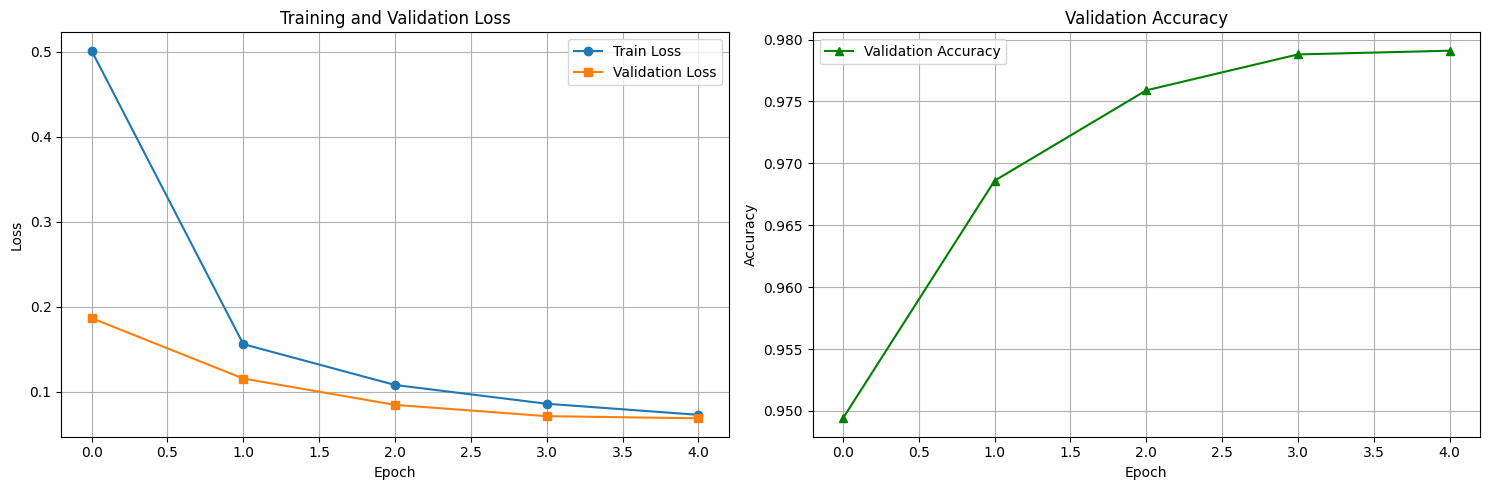

In [84]:
plot_training_results(log_adadelta_nll['train_losses'], 
                      log_adadelta_nll['val_losses'], 
                      log_adadelta_nll['val_accuracies'], 
                      log_adadelta_nll['epochs'])

In [85]:
log_adadelta_nll['val_accuracies']

[np.float64(0.9494),
 np.float64(0.9686),
 np.float64(0.9759),
 np.float64(0.9788),
 np.float64(0.9791)]

In [86]:
num_filters = 16
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=5),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   
    nn.Flatten(),
    nn.Linear(6*6*num_filters, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.05)

In [87]:
log_adadelta_kl = train_kl_div(model, optimizer, n_epochs=5)

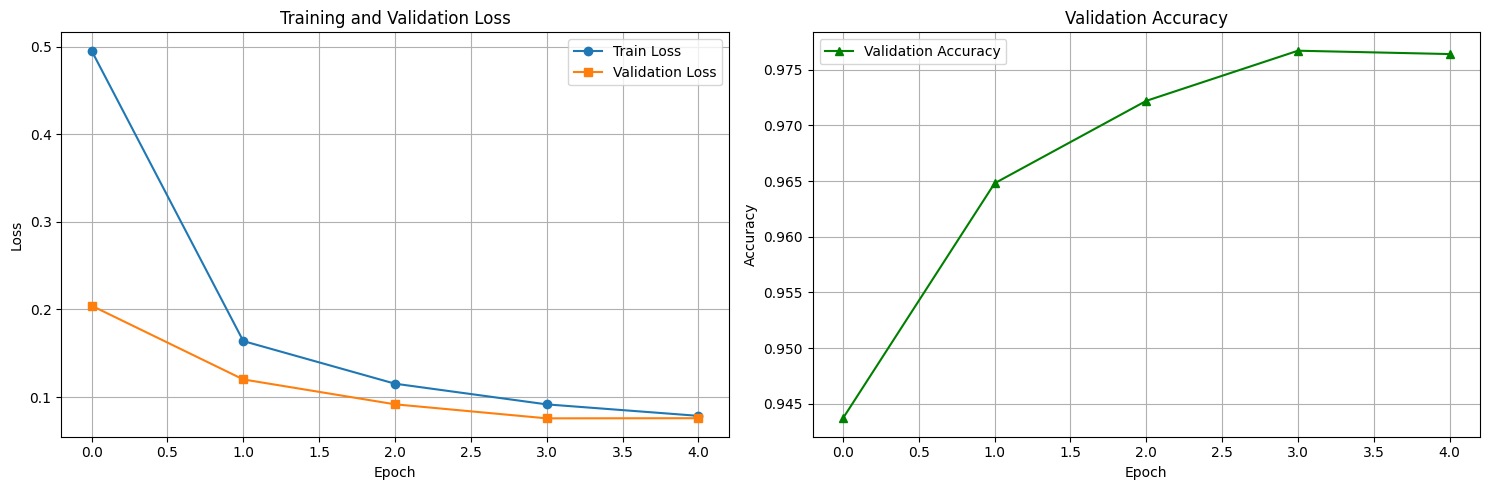

In [88]:
plot_training_results(log_adadelta_kl['train_losses'], 
                      log_adadelta_kl['val_losses'], 
                      log_adadelta_kl['val_accuracies'], 
                      log_adadelta_kl['epochs'])

In [89]:
log_adadelta_kl['val_accuracies']

[np.float64(0.9437),
 np.float64(0.9648),
 np.float64(0.9722),
 np.float64(0.9767),
 np.float64(0.9764)]